In [1]:
# EVDS and its prerequisite packages are installed here.
install.packages("devtools")
devtools::install_github("algopoly/EVDS", force = TRUE)
install.packages("ggplot2")
install.packages("data.table")
install.packages("forecast")

# setting EVDS key
EVDS::set_evds_key("UIwrpiUF7p")


The downloaded binary packages are in
	/var/folders/l6/wqchkt9s6z98z9gzyxz426080000gn/T//Rtmpdng6Dl/downloaded_packages



✔  checking for file ‘/private/var/folders/l6/wqchkt9s6z98z9gzyxz426080000gn/T/Rtmpdng6Dl/remotes164e1370aacf/algopoly-EVDS-a806c80/DESCRIPTION’
─  preparing ‘EVDS’:
✔  checking DESCRIPTION meta-information
─  checking for LF line-endings in source and make files and shell scripts
─  checking for empty or unneeded directories
─  building ‘EVDS_0.2.0.tar.gz’
   

The downloaded binary packages are in
	/var/folders/l6/wqchkt9s6z98z9gzyxz426080000gn/T//Rtmpdng6Dl/downloaded_packages

The downloaded binary packages are in
	/var/folders/l6/wqchkt9s6z98z9gzyxz426080000gn/T//Rtmpdng6Dl/downloaded_packages

The downloaded binary packages are in
	/var/folders/l6/wqchkt9s6z98z9gzyxz426080000gn/T//Rtmpdng6Dl/downloaded_packages


EVDS requires an API key from CBRT. Get yours from https://evds2.tcmb.gov.tr/index.php?/evds/editProfile 

      All functions require an API key so you should set your key with set_evds_key("YOURAPIKEY") function.



In [2]:
library(EVDS)
library(ggplot2)
library(data.table)
library(forecast)

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 



In [3]:
# the dates in the series are not formatted in any built-in type, so I've written a formatter
special_dateconv <- function(x) {
    tokens <- unlist(strsplit(x, "-"))
    month_length <- nchar(tokens[2])
    if (month_length == 1) {
        tokens[2] <- paste("0", tokens[2], sep = "")
    }
    tokens <- append(tokens, c("01"))
    str_date <- paste(tokens, collapse = "-")
    str_date
}

In [4]:
main_data <- get_series(series = c("TP.AC2.TOP.A"), start_date = "01-01-2010", end_date = "01-03-2021")

In [5]:
dataframe <- data.frame(main_data$items$Tarih, main_data$items$TP_AC2_TOP_A)
names(dataframe)[names(dataframe) == "main_data.items.Tarih"] <- "Date"
names(dataframe)[names(dataframe) == "main_data.items.TP_AC2_TOP_A"] <- "NET_Number"
dataframe[, "NET_Number"] <- as.numeric(dataframe[, "NET_Number"])
dataframe[1] <- apply(dataframe[1], FUN = special_dateconv, MARGIN = 1)
dataframe$Date <- as.Date(dataframe$Date, format = "%Y-%m-%d")

In [6]:
datatable = data.table(dataframe)
datatable[, log_NET_Number:=log(dataframe[2])]
datatable[, trend:=1:.N]
month = seq(1, 12, by=1)
datatable = cbind(datatable, month)

Warning message in as.data.table.list(x, keep.rownames = keep.rownames, check.names = check.names, :
“Item 2 has 12 rows but longest item has 135; recycled with remainder.”


In [ ]:
head(datatable)

In [ ]:
fit1 <- lm(log_NET_Number~trend, data=datatable)

In [ ]:
summary(fit1)
plot(fit1)
checkresiduals(fit1, lag=12)

In [ ]:
fit2 <- lm(log_NET_Number~trend+as.factor(month), data = datatable)

In [ ]:
summary(fit2)
plot(fit2)
checkresiduals(fit2, lag=12)

In [7]:
supplementary_data <- get_series(series = c("TP.KAP2.TOP.A"), start_date = "01-01-2010", end_date = "01-03-2021")

In [8]:
datatable[, LT_Number:=as.numeric(supplementary_data$items$TP_KAP2_TOP_A)]
datatable[, log_LT_Number:=log(datatable[,"LT_Number"])]

In [ ]:
fit3 <- lm(diff(log_NET_Number)~diff(log_LT_Number), data = datatable)

In [ ]:
summary(fit3)
plot(fit3)
checkresiduals(fit3, lag=12)

In [ ]:
fit4 <- lm(log_NET_Number~trend+as.factor(month)+as.factor(log_LT_Number), data=datatable)

In [ ]:
summary(fit4)
plot(fit4)
checkresiduals(fit4, lag=12)

In [9]:
lagged_log_NET_Number <- datatable$log_NET_Number[2:nrow(datatable)]
str(lagged_log_NET_Number)
lagged_log_NET_Number <- c(lagged_log_NET_Number, rep(lagged_log_NET_Number[1], 1))
str(lagged_log_NET_Number)
datatable[, lagged_log_NET_Number:=lagged_log_NET_Number]
lagged_log_LT_Number <- datatable$log_LT_Number[2:nrow(datatable)]
str(lagged_log_LT_Number)
lagged_log_LT_Number <- c(lagged_log_LT_Number, rep(lagged_log_LT_Number[1], 1))
str(lagged_log_LT_Number)
datatable[, lagged_log_LT_Number:=lagged_log_LT_Number]

 num [1:134] 8.35 8.53 8.4 8.31 8.37 ...
 num [1:135] 8.35 8.53 8.4 8.31 8.37 ...
 num [1:134] 6.97 6.9 6.82 6.71 7.04 ...
 num [1:135] 6.97 6.9 6.82 6.71 7.04 ...


In [ ]:
fit5 <- lm(log_NET_Number~trend+as.factor(month)+log_LT_Number, data = datatable)

In [ ]:
summary(fit5)
plot(fit5)
checkresiduals(fit5, lag=12)

In [10]:
datatable[, PandemicClosure:=c(rep(0, 122), rep(1,3), rep(0,10))]

In [ ]:
fit6 <- lm(log_NET_Number~trend+as.factor(month)+as.factor(PandemicClosure), data = datatable)

In [ ]:
summary(fit6)
plot(fit6)
checkresiduals(fit6, lag=12)

In [11]:
fit7 <- lm(log_NET_Number~trend+as.factor(month)+as.factor(PandemicClosure)+log_LT_Number+lagged_log_NET_Number+lagged_log_LT_Number, data = datatable)


Call:
lm(formula = log_NET_Number ~ trend + as.factor(month) + as.factor(PandemicClosure) + 
    log_LT_Number + lagged_log_NET_Number + lagged_log_LT_Number, 
    data = datatable)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.41323 -0.07981  0.00040  0.10088  0.53324 

Coefficients:
                              Estimate Std. Error t value Pr(>|t|)    
(Intercept)                  3.7063298  0.8028309   4.617 1.00e-05 ***
trend                        0.0037256  0.0005953   6.258 6.50e-09 ***
as.factor(month)2            0.1277886  0.0909873   1.404 0.162807    
as.factor(month)3            0.2997990  0.0919808   3.259 0.001459 ** 
as.factor(month)4            0.1719763  0.0978359   1.758 0.081374 .  
as.factor(month)5            0.1973701  0.1028722   1.919 0.057451 .  
as.factor(month)6            0.1624014  0.0963035   1.686 0.094371 .  
as.factor(month)7            0.0148902  0.0866676   0.172 0.863882    
as.factor(month)8            0.0294738  0.0954934   0.309 0

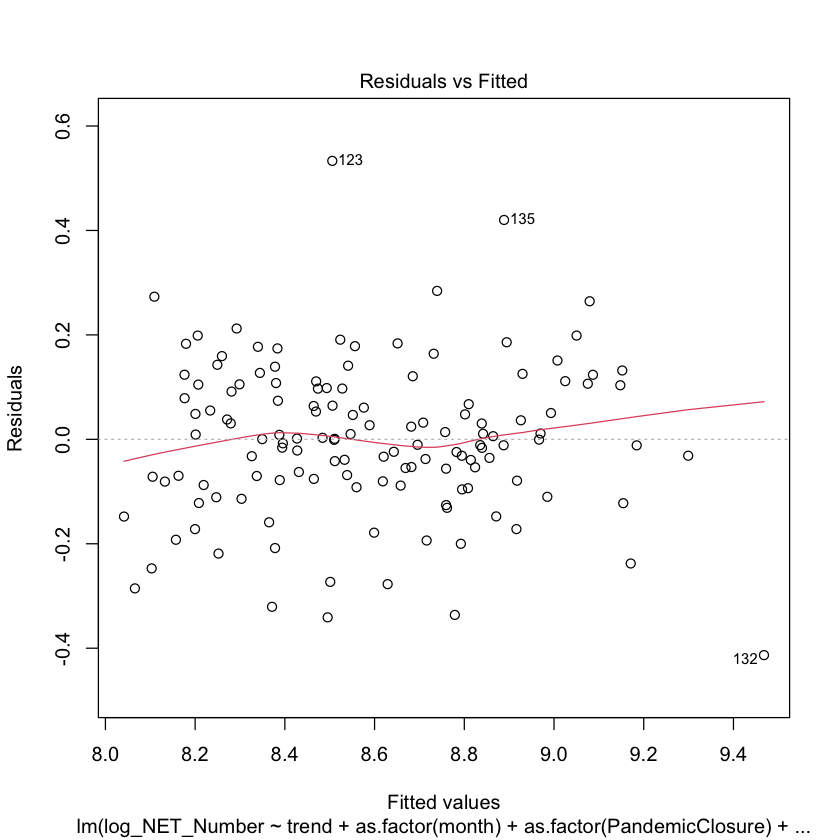

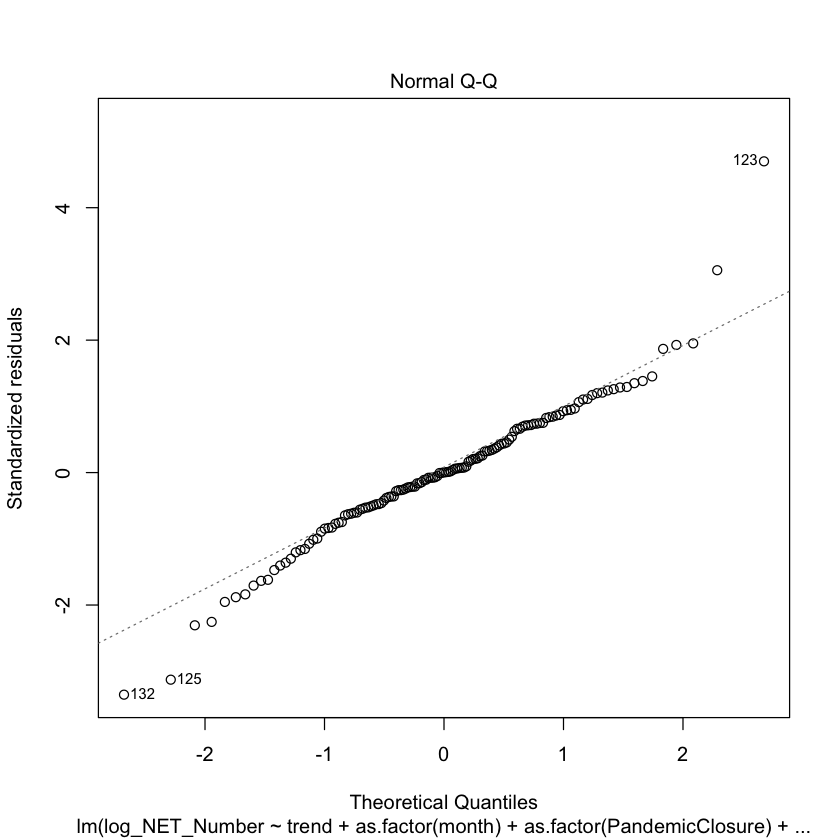

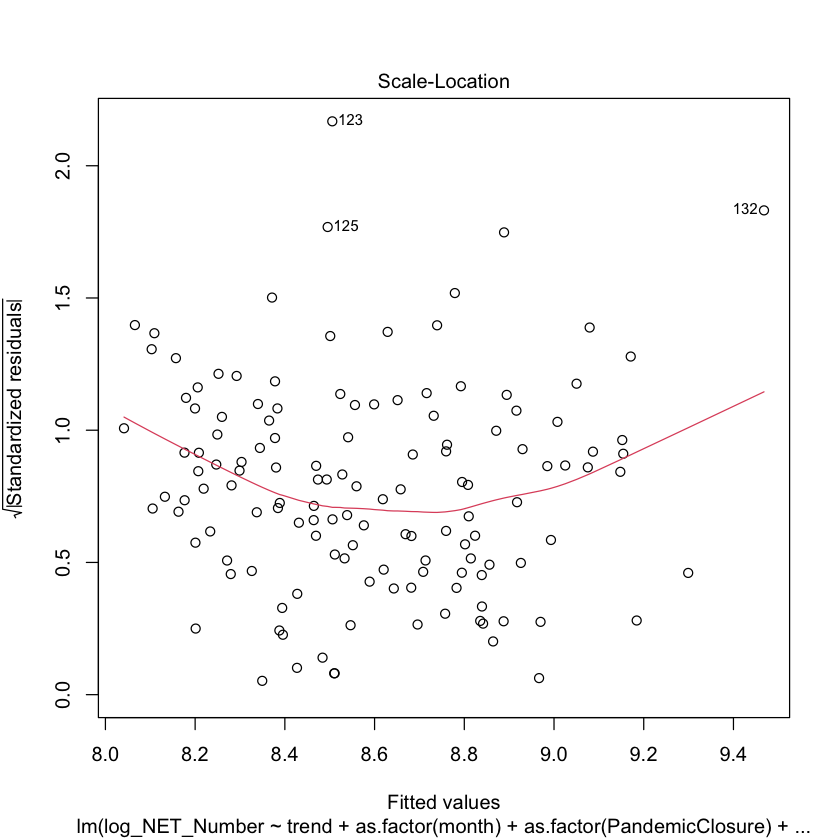

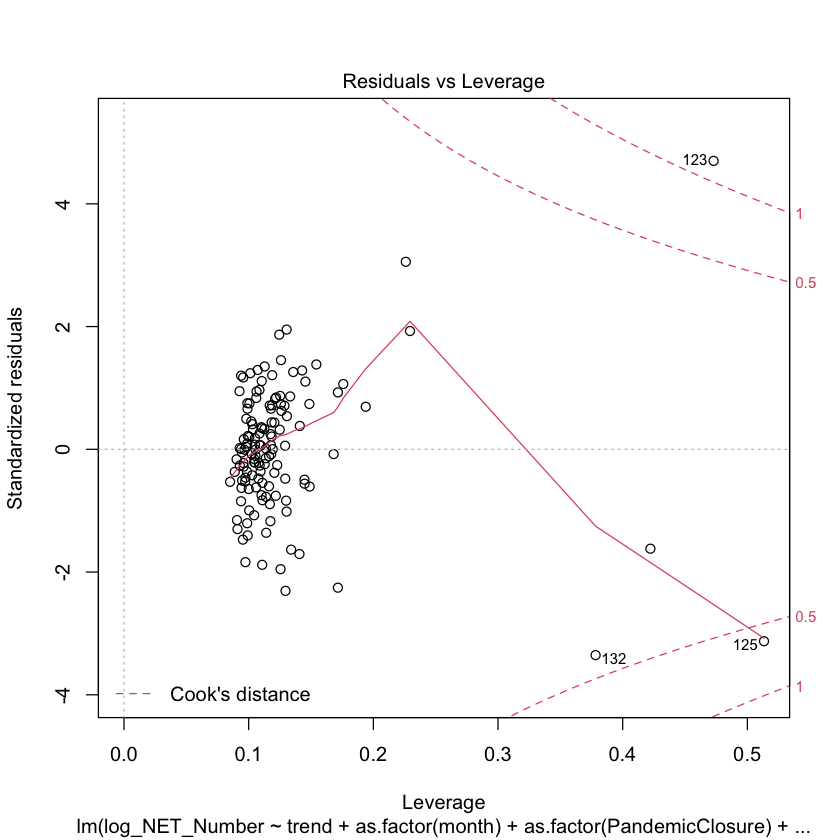


	Breusch-Godfrey test for serial correlation of order up to 12

data:  Residuals
LM test = 44.838, df = 12, p-value = 1.098e-05


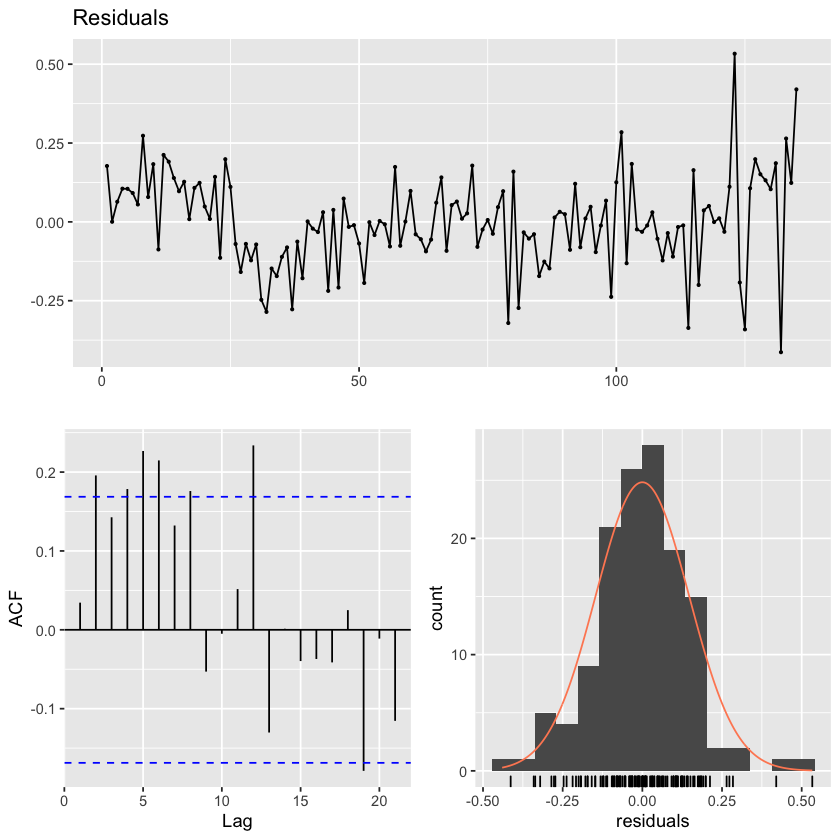

In [12]:
summary(fit7)
plot(fit7)
checkresiduals(fit7, lag=12)

In [ ]:
options(repr.plot.width=30, repr.plot.height=18)
ggplot(dataframe, aes(x=Date,y=NET_Number)) +
geom_line(data=dataframe, aes(x=Date, y=NET_Number, colour = "real")) +
geom_smooth(se=FALSE, colour = "blue") +
labs(colour = "Data Types", title = "Newly Established Totals as Numbers", y="NET Number") +
theme(legend.text = element_text(size = 16), 
      axis.title.y = element_text(size = 19), 
      axis.title.x = element_text(size = 19), 
      axis.text.x = element_text(size = 15), 
      axis.text.y = element_text(size = 15), 
      plot.title = element_text(size = 22, hjust = 0.5))

In [ ]:
options(repr.plot.width=30, repr.plot.height=18)
ggplot(data=datatable, aes(x=Date,y=LT_Number)) +
geom_smooth(se=FALSE, colour = "blue") +
geom_line(data=datatable, aes(x=Date, y=LT_Number, colour = "real")) +
labs(colour = "Data Types", title = "Newly Established Totals as Numbers", y="NET Number") +
theme(legend.text = element_text(size = 16), 
      axis.title.y = element_text(size = 19), 
      axis.title.x = element_text(size = 19), 
      axis.text.x = element_text(size = 15), 
      axis.text.y = element_text(size = 15), 
      plot.title = element_text(size = 22, hjust = 0.5))

In [14]:
datatable <- rbind(datatable, data.table(Date=as.Date("2021-04-01")), fill=TRUE)
datatable[Date==as.Date("2021-04-01"), trend:=136]
datatable[Date==as.Date("2021-04-01"), month:=4]
datatable[Date==as.Date("2021-04-01"), LT_Number:=datatable[.N-1, LT_Number]]
datatable[Date==as.Date("2021-04-01"), log_LT_Number:=datatable[.N-1, log_LT_Number]]
datatable[Date==as.Date("2021-04-01"), lagged_log_NET_Number:=datatable[.N-1, lagged_log_NET_Number]]
datatable[Date==as.Date("2021-04-01"), lagged_log_LT_Number:=datatable[.N-1, lagged_log_LT_Number]]
datatable[Date==as.Date("2021-04-01"), PandemicClosure:=datatable[.N-1,PandemicClosure]]

In [22]:
april_prediction <- predict(fit7, datatable[Date==as.Date("2021-04-01")])

In [29]:
datatable[Date==as.Date("2021-04-01"), log_NET_Number:=april_prediction]
datatable[Date==as.Date("2021-04-01"), NET_Number:=round(exp(april_prediction))]

In [31]:
tail(datatable, n=1)

Date,NET_Number,log_NET_Number,trend,month,LT_Number,log_LT_Number,lagged_log_NET_Number,lagged_log_LT_Number,PandemicClosure
<date>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2021-04-01,6403,8.764544,136,4,1015,6.922644,8.349957,6.969791,0


In [ ]:
options(repr.plot.width=30, repr.plot.height=18)
ggplot(data=datatable, aes(x=Date,y=LT_Number)) +
geom_line(data=datatable, aes(x=Date, y=log_NET_Number, colour = "real")) +
geom_line(data=datatable, aes(x=Date, y=predictions, colour = "pred")) +
scale_colour_manual("", breaks = c("real", "pred"), values = c("red", "purple")) +
labs(colour = "Data Types", title = "Newly Established Totals as Numbers", y="NET Number") +
theme(legend.text = element_text(size = 16), 
      axis.title.y = element_text(size = 19), 
      axis.title.x = element_text(size = 19), 
      axis.text.x = element_text(size = 15), 
      axis.text.y = element_text(size = 15), 
      plot.title = element_text(size = 22, hjust = 0.5))